In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
vocab_size = 256 
x_ = list(map(ord, "hello"))
y_ = list(map(ord, "hola"))
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # Encoder Input
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)

        # Encoder
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        
        # Decoder Input
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        # Decoder
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection)
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()


In [5]:
seq2seq = Seq2Seq(vocab_size, 16)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr = 1e-3)

In [7]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n Iteration:%d Error: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 Iteration:0 Error: 5.754757881164551
['P', '\x99', '\x99', 'ÿ']

 Iteration:100 Error: 2.153998851776123
['h', 'o', 'o', 'a']

 Iteration:200 Error: 0.636938214302063
['h', 'o', 'l', 'a']

 Iteration:300 Error: 0.30297693610191345
['h', 'o', 'l', 'a']

 Iteration:400 Error: 0.18490251898765564
['h', 'o', 'l', 'a']

 Iteration:500 Error: 0.12931481003761292
['h', 'o', 'l', 'a']

 Iteration:600 Error: 0.09723867475986481
['h', 'o', 'l', 'a']

 Iteration:700 Error: 0.07597137987613678
['h', 'o', 'l', 'a']

 Iteration:800 Error: 0.0606851726770401
['h', 'o', 'l', 'a']

 Iteration:900 Error: 0.04929089546203613
['h', 'o', 'l', 'a']


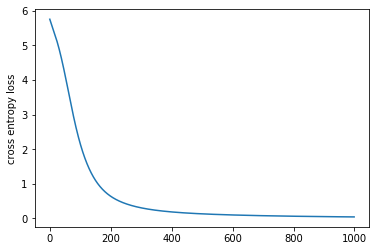

In [8]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()